In [1]:
import torch
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

from pathlib import Path
home = str(Path.home())
sns.set_style("darkgrid")

In [2]:
att_dict = torch.load(home+'/snap/interpret.pth', map_location=torch.device('cpu'))

In [3]:
att_dict.keys()

dict_keys(['lang_att_0', 'lang_att_1', 'lang_att_2', 'lang_att_3', 'lang_att_4', 'lang_att_5', 'lang_att_6', 'lang_att_7', 'lang_att_8', 'visn_att_0', 'visn_att_1', 'visn_att_2', 'visn_att_3', 'visn_att_4', 'cross_att_0', 'cross_att_1', 'cross_att_2', 'cross_att_3', 'cross_att_4'])

In [4]:
lang_att_0 = att_dict['lang_att_0']
lang_att_8 = att_dict['lang_att_8']

In [5]:
probs_0 = lang_att_0['attention_probs']
probs_8 = lang_att_8['attention_probs']

In [6]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [9]:
probs_0.shape

torch.Size([128, 12, 20, 20])

In [102]:
data = probs_0.detach().numpy()
n_docs = len(data)

In [103]:
def data_iterator():
    for i, doc in enumerate(data):
        if i % 100 == 0 or i == len(data) - 1:
            print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
        yield ["hello"], doc

In [124]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "what", "is", "the", "man", "doing"]
}

print("Computing token stats")
for tokens, attns in data_iterator():
  n_tokens = attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "what": np.eye(n_tokens, n_tokens),
      "is": np.eye(n_tokens, n_tokens, 1),
      "the": np.eye(n_tokens, n_tokens, -1),
      #"man": np.tile(seps[np.newaxis], [n_tokens, 1]),
      #"doing": sep_seps,
      #"rest_sep": rest_seps,
      #"cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      #"punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom))

Computing token stats
0.8% done
78.9% done
100.0% done


In [125]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in data_iterator():
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

Computing entropy stats
0.8% done
78.9% done
100.0% done


In [126]:
def add_line(key, ax, color, label, plot_avgs=True):
    xs, ys, avgs = get_data_points(avg_attns[key])
    ax.scatter(xs, ys, s=12, label=label, color=color)
    if plot_avgs:
        ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
    ax.legend(loc="best")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Avg. Attention")

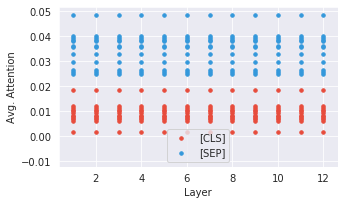

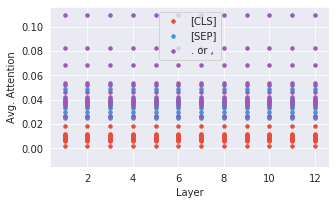

In [130]:
plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("what", RED, "[CLS]"),
    ("is", BLUE, "[SEP]"),
    ("the", PURPLE, ". or ,"),
]:
    add_line(key, ax, color, label)
    
plt.show()

In [109]:
def get_data_points(head_data):
    xs, ys, avgs = [], [], []
    for layer in range(12):
        for head in range(12):
            ys.append(head_data[layer, head])
            xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
    return xs, ys, avgs

In [75]:
xs, ys, avgs = get_data_points(probs_0.detach().numpy())

In [77]:
len(xs), len(ys)

144

In [79]:
xs[0], ys[0].shape

(1, (20, 20))

In [76]:
len(xs[0])

TypeError: object of type 'int' has no len()

In [64]:
xs[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [13]:
probs_0[0,0].shape

torch.Size([20, 20])

In [14]:
probs_0.size(2)

20

In [15]:
def add_line(key, ax, color, label, plot_avgs=True):
    xs, ys, avgs = get_data_points(probs.detach().numpy())
    ax.scatter(xs, ys, s=12, label=label, color=color)
    if plot_avgs:
        ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
    ax.legend(loc="best")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Avg. Attention")

In [75]:
avgs

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

In [34]:
ys[1].shape

(20,)

In [77]:
len(xs), len(ys), len(avgs)

(144, 144, 12)

In [78]:
ys[0].shape

(20, 20)

In [ ]:
1

In [ ]:
plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
ax.scatter(xs,ys)
#ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
ax.legend(loc="best")
ax.set_xlabel("Layer")
ax.set_ylabel("Avg. Attention")
plt.show()

In [73]:
plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
    add_line(key, ax, color, label)

ValueError: x and y must be the same size